# Кластеризация

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [19]:
import inspect
import random
from abc import ABC
from typing import Callable, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from PIL import Image
from sklearn.datasets import make_blobs, make_moons
from sklearn.neighbors import KDTree

In [20]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)


# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)
def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


SEED = 0xC0FFEE
set_seed(SEED)

In [21]:
def visualize_clusters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()


def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter(
            [p[first_color] for p in flatten_image],
            [p[second_color] for p in flatten_image],
            c=flatten_image,
            marker=".",
        )
        axes_pair[1].scatter(
            [p[first_color] for p in flatten_image],
            [p[second_color] for p in flatten_image],
            c=[cluster_colors[c] for c in cluster_labels],
            marker=".",
        )
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

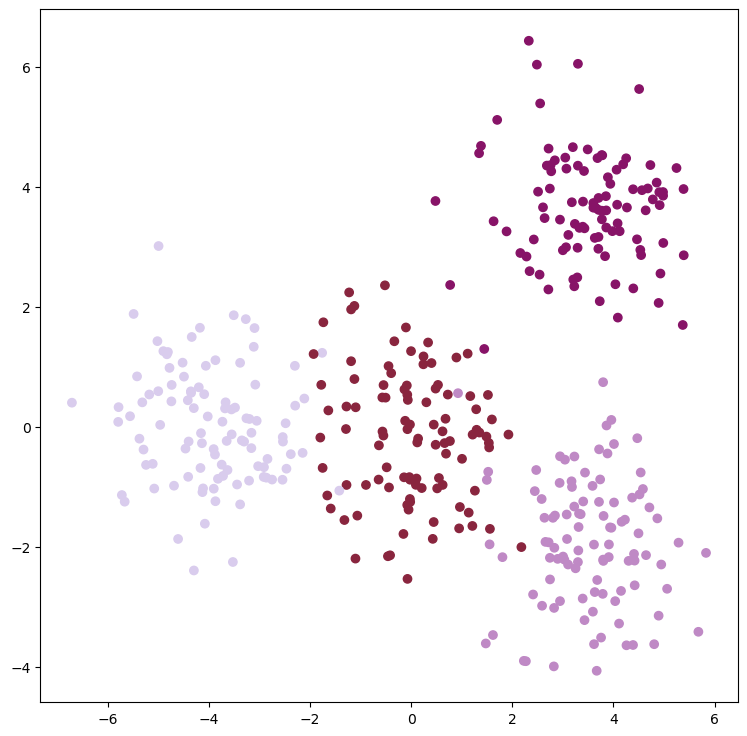

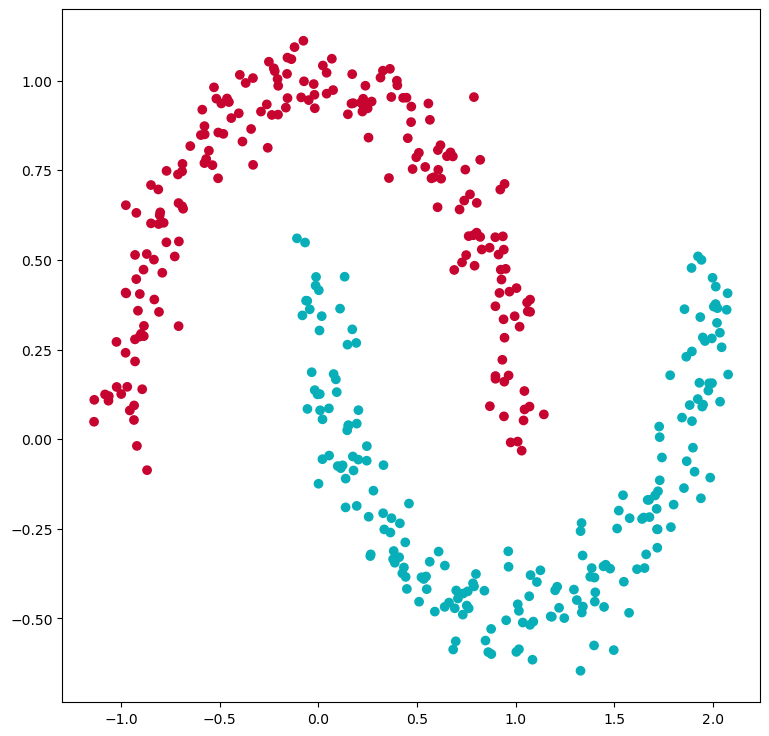

In [22]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clusters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clusters(X_2, true_labels)

Также реализуем необходимые функции для вычисления расстояний между точками

In [23]:
def get_euclidean_distances(from_points: ndarray, to_points: ndarray) -> ndarray:
    """Calculate euclidian distance between points

    Args:
        from_points: array of [source_points; dim] points
        to_points: array of [target_points; dim] points

    Returns:
        distances: array of [source_points; target_points]
    """
    return np.sqrt(((from_points[:, np.newaxis] - to_points)**2).sum(axis=2))


def get_manhattan_distances(from_points: ndarray, to_points: ndarray) -> ndarray:
    """Calculate manhattan distance between points

    Args:
        from_points: array of [source_points; dim] points
        to_points: array of [target_points; dim] points

    Returns:
        distances: array of [source_points; target_points]
    """
    return np.abs(from_points[:, np.newaxis] - to_points).sum(axis=2)


def get_chebyshev_distance(from_points: ndarray, to_points: ndarray) -> ndarray:
    """Calculate chebyshev distance between points

    Args:
        from_points: array of [source_points; dim] points
        to_points: array of [target_points; dim] points

    Returns:
        distances: array of [source_points; target_points]
    """
    return np.max(np.abs(from_points[:, np.newaxis] - to_points), axis=2)

## K-Means (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

**Описание методов**

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.

`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

Не забудьте реинициализировать пустые кластеры!

In [24]:
class AbstractCentroidBuilder(ABC):
    name: str = None

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        """Generating centroids from points

        Args:
            x: array of [n_points; dim] points
            k: number of centroids to generate

        """
        raise NotImplementedError()

    @staticmethod
    def _validate_centroids(x: ndarray, centroids: ndarray) -> bool:
        """Validating that each centroid has at least one point next to it"""
        if len(centroids) == 0:
            return False
        distances = get_euclidean_distances(x, centroids)
        closest_centroids = np.argmin(distances, axis=1)
        unique_centroids = np.unique(closest_centroids)
        return len(unique_centroids) == len(centroids)

    def build(self, x: ndarray, k: int) -> ndarray:
        """Build valid centroids that have points assigned to them"""
        max_attempts = 100
        for _ in range(max_attempts):
            centroids = self._generate_centroids(x, k)
            if self._validate_centroids(x, centroids):
                return centroids
        return x[np.random.choice(len(x), size=k, replace=False)]


class RandomCentroidBuilder(AbstractCentroidBuilder):
    name: str = "random"

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        mins = x.min(axis=0)
        maxs = x.max(axis=0)
        return np.random.uniform(mins, maxs, size=(k, x.shape[1]))

class SampleCentroidBuilder(AbstractCentroidBuilder):
    name: str = "sample"

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        indices = np.random.choice(len(x), size=k, replace=False)
        return x[indices]

class KMeansPlusCentroidBuilder(AbstractCentroidBuilder):
    name: str = "kmeans++"

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        centroids = [x[np.random.randint(len(x))]]
        for _ in range(1, k):
            dists = np.min(get_euclidean_distances(x, np.array(centroids)), axis=1)
            probs = dists / dists.sum()
            centroids.append(x[np.random.choice(len(x), p=probs)])
        return np.array(centroids)

In [25]:
class KMeans:
    _known_centroid_builders: Dict[str, AbstractCentroidBuilder.__class__] = {
        RandomCentroidBuilder.name: RandomCentroidBuilder,
        SampleCentroidBuilder.name: SampleCentroidBuilder,
        KMeansPlusCentroidBuilder.name: KMeansPlusCentroidBuilder,
    }

    _centroids: ndarray = None
    _x: ndarray = None
    _clusters_ids: ndarray = None

    def __init__(self, n_clusters: int, init: str = "random", max_iter: int = 300):
        """KMeans clusterization

        Args:
            n_clusters: number of clusters
            init: strategy to initialize clusters, one of "random", "sample", and "k-means++"
            max_iter: maximum number of iterations
        """
        self._n_clusters = n_clusters
        self._max_iter = max_iter
        if init not in self._known_centroid_builders:
            raise ValueError(f"Unknown way to initialize clusters centroids: {init}")
        self._centroid_builder = self._known_centroid_builders[init]()

    def fit(self, x: ndarray, y: ndarray = None):
        """Build centroids based on X

        Args:
            x: input points, array of [n_points; dim]
            y: ignored, to mactch sklearn behaviour
        """
        self._centroids = self._centroid_builder.build(x, self._n_clusters)
        for _ in range(self._max_iter):
            distances = get_euclidean_distances(x, self._centroids)
            labels = np.argmin(distances, axis=1)
            new_centroids = np.array([x[labels == i].mean(axis=0) for i in range(self._n_clusters)])
            if np.allclose(new_centroids, self._centroids):
                break
            self._centroids = new_centroids

    def predict(self, x: np.array) -> np.array:
        """For each element of input returns corresponding cluster index

        Args:
            x: input points, array of [n_points; dim]

        Return
            labels: cluster ids, array of [n_points]
        """
        if self._centroids is None:
            raise RuntimeError("Fit estimator before predicting")
        distances = get_euclidean_distances(x, self._centroids)
        return np.argmin(distances, axis=1)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

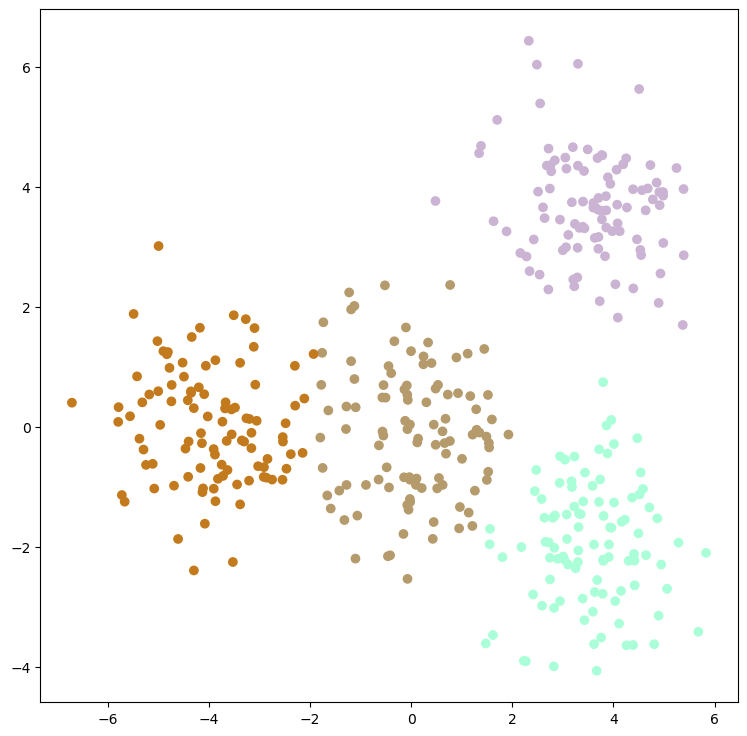

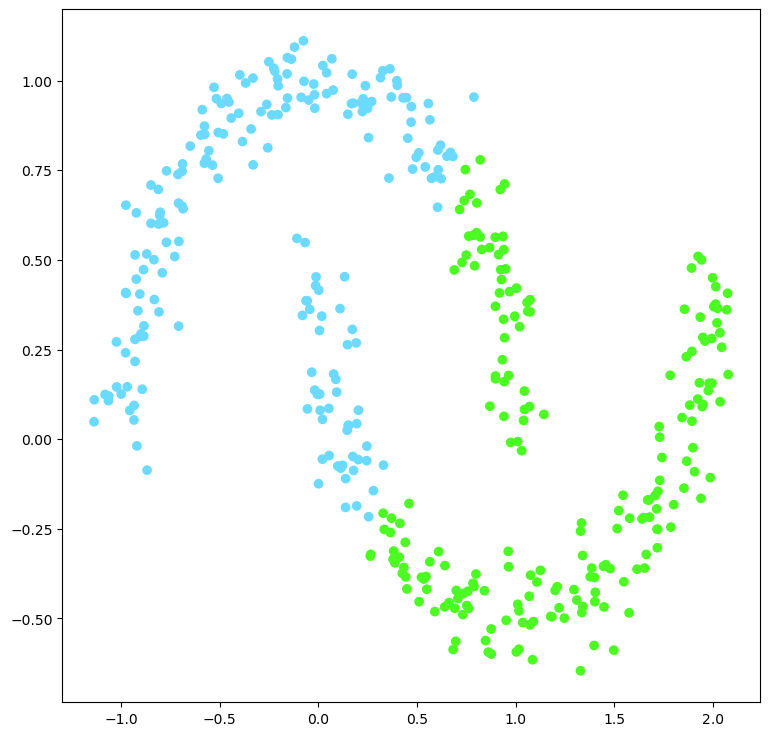

In [26]:
kmeans = KMeans(n_clusters=4, init="kmeans++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clusters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="kmeans++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clusters(X_2, labels)

## DBScan (3 балла)
В отличие от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

**Описание методов**

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

**Возможные метрики**

`euclidean`, `manhattan`, `chebyshev`

Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`

In [27]:
class DBScan:
    _known_metric_functions: Dict[str, Callable] = {
        "euclidean": get_euclidean_distances,
        "manhattan": get_manhattan_distances,
        "chebyshev": get_chebyshev_distance,
    }

    def __init__(self, eps: float = 0.5, min_samples: int = 5, leaf_size: int = 40, metric: str = "euclidean"):
        self._eps = eps
        self._min_samples = min_samples
        self._metric = metric
        self._get_distance = self._known_metric_functions[metric]
        self._kdtree_leaf_size = leaf_size

    def fit_predict(self, x: ndarray, y=None) -> ndarray:
        tree = KDTree(x, leaf_size=self._kdtree_leaf_size, metric=self._metric)
        neighbors = tree.query_radius(x, r=self._eps)

        n_samples = x.shape[0]
        labels = np.full(n_samples, -1, dtype=int)
        cluster_id = 0

        for i in range(n_samples):
            if labels[i] != -1:
                continue

            if len(neighbors[i]) < self._min_samples:
                labels[i] = -1
                continue

            labels[i] = cluster_id
            seeds = set(neighbors[i]) - {i}

            while seeds:
                j = seeds.pop()

                if labels[j] == -1:
                    labels[j] = cluster_id
                elif labels[j] != -1:
                    continue

                j_neighbors = tree.query_radius([x[j]], r=self._eps)[0]
                if len(j_neighbors) >= self._min_samples:
                    seeds.update(j_neighbors)

            cluster_id += 1

        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

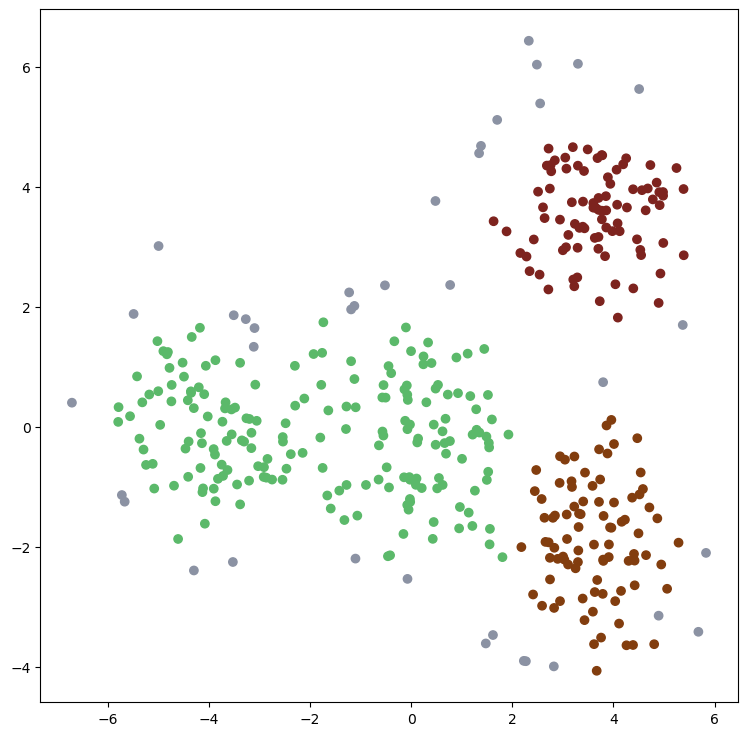

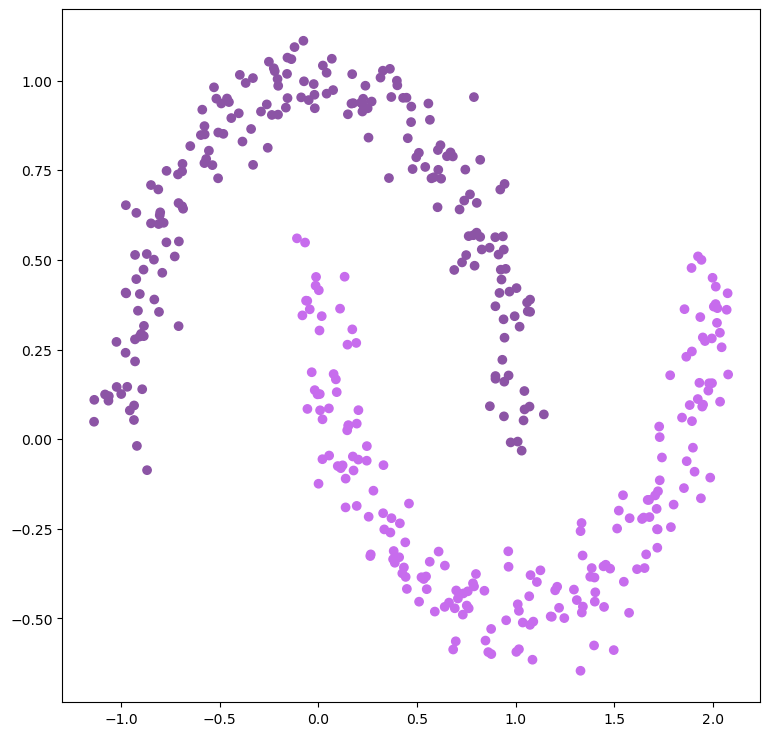

In [28]:
dbscan = DBScan(eps=0.6)
labels = dbscan.fit_predict(X_1)
visualize_clusters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clusters(X_2, labels)

## Agglomerative Clustering (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

**Описание методов**

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

### Linkage
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

Для быстрого вычисления воспользуемся формулой Ланса-Уильямса

$$
D(W, S) = \alpha_U D(U, S) + \alpha_V D(V, S) + \beta D(U, V) + \gamma \left| D(U, S) - D(V, S) \right|
$$


| Метод агломерации         | α<sub>U</sub>                             | α<sub>V</sub>                             | β                                       | γ       |
|--------------------------|------------------------------------------|------------------------------------------|-----------------------------------------|----------|
| Single linkage           | 0.5                                      | 0.5                                      | 0                                       | -0.5     |
| Complete linkage         | 0.5                                      | 0.5                                      | 0                                       | +0.5     |
| Average linkage          | n<sub>U</sub> / (n<sub>U</sub> + n<sub>V</sub>) | n<sub>V</sub> / (n<sub>U</sub> + n<sub>V</sub>) | 0                                       | 0        |
| Centroid linkage         | n<sub>U</sub> / (n<sub>U</sub> + n<sub>V</sub>) | n<sub>V</sub> / (n<sub>U</sub> + n<sub>V</sub>) | -n<sub>U</sub>n<sub>V</sub> / (n<sub>U</sub> + n<sub>V</sub>)² | 0        |
| Ward's method            | (n<sub>S</sub> + n<sub>U</sub>) / (n<sub>S</sub> + n<sub>U</sub> + n<sub>V</sub>) | (n<sub>S</sub> + n<sub>V</sub>) / (n<sub>S</sub> + n<sub>U</sub> + n<sub>V</sub>) | -n<sub>S</sub> / (n<sub>S</sub> + n<sub>U</sub> + n<sub>V</sub>) | 0        |

In [29]:
# Return coefficients based on Lance–Williams formula for different linkages


def get_average_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    alpha_u = u_size / (u_size + v_size)
    alpha_v = v_size / (u_size + v_size)
    return alpha_u, alpha_v, 0.0, 0.0

def get_single_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    return 0.5, 0.5, 0.0, -0.5

def get_complete_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    return 0.5, 0.5, 0.0, 0.5

In [30]:
class AgglomerativeClustering:
    _known_linkages = {
        "average": get_average_linkage_params,
        "single": get_single_linkage_params,
        "complete": get_complete_linkage_params,
    }

    def __init__(self, n_clusters: int = 2, linkage: str = "average"):  # Изменил дефолтное значение на 2
        self.n_clusters = n_clusters
        if linkage not in self._known_linkages:
            raise ValueError(f"Unknown linkage: {linkage}")
        self.linkage_func = self._known_linkages[linkage]

    def fit_predict(self, x: ndarray, y=None) -> ndarray:
        n_samples = x.shape[0]
        
        labels = np.arange(n_samples)
        current_clusters = [[i] for i in range(n_samples)]
        
        dist_matrix = get_euclidean_distances(x, x)
        np.fill_diagonal(dist_matrix, np.inf)
        
        while len(current_clusters) > self.n_clusters:
            i, j = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
            if i > j:
                i, j = j, i
                
            u_size = len(current_clusters[i])
            v_size = len(current_clusters[j])
            alpha_u, alpha_v, beta, gamma = self.linkage_func(u_size, v_size)
            
            for k in range(len(current_clusters)):
                if k == i or k == j:
                    continue
                    
                d_ui = dist_matrix[min(i,k), max(i,k)]
                d_vj = dist_matrix[min(j,k), max(j,k)]
                d_uv = dist_matrix[i,j]
                
                new_dist = (alpha_u * d_ui + alpha_v * d_vj + 
                           beta * d_uv + gamma * abs(d_ui - d_vj))
                dist_matrix[min(i,k), max(i,k)] = new_dist
            
            merged_cluster = current_clusters[i] + current_clusters[j]
            current_clusters[i] = merged_cluster
            
            for idx in merged_cluster:
                labels[idx] = min(labels[merged_cluster[0]], labels[idx])
            
            current_clusters.pop(j)
            dist_matrix = np.delete(dist_matrix, j, axis=0)
            dist_matrix = np.delete(dist_matrix, j, axis=1)
            
        unique_labels = np.unique(labels)
        label_map = {old: new for new, old in enumerate(unique_labels)}
        return np.array([label_map[l] for l in labels])

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

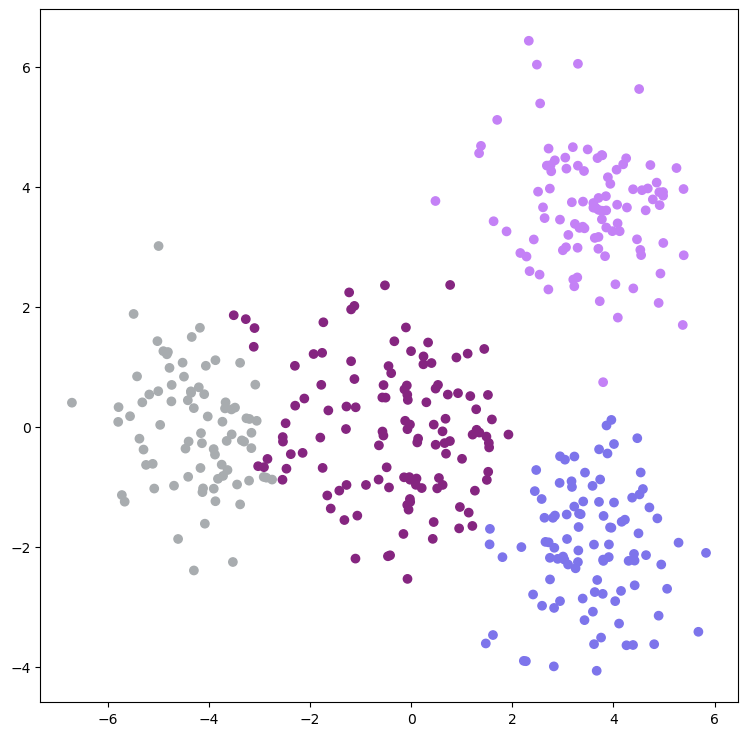

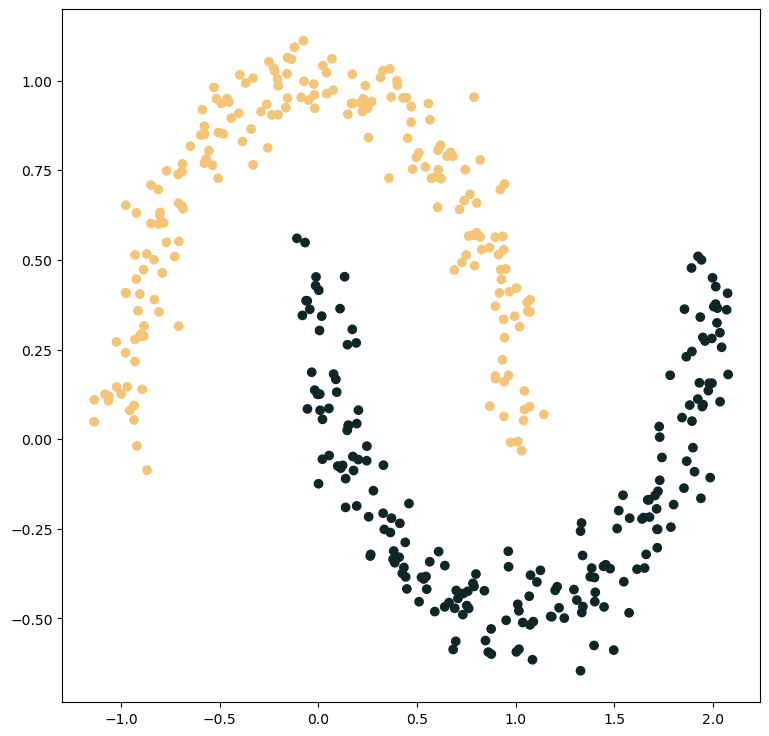

In [32]:
agg_clustering = AgglomerativeClustering(4, "complete")
labels = agg_clustering.fit_predict(X_1)
visualize_clusters(X_1, labels)

agg_clustering = AgglomerativeClustering(2, "single")
labels = agg_clustering.fit_predict(X_2)
visualize_clusters(X_2, labels)

## Сжатие изображений (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки [`Pillow`](https://github.com/python-pillow/Pillow).

Нормализованное изображение - это изображение, у которого все значения пикселей находятся в $[0; 1]$.

In [33]:
def read_image(path: str) -> ndarray:
    img = Image.open(path)
    return np.array(img) / 255.0


def show_image(image: ndarray):
    """Display the image using matplotlib

    Args:
        image: normalized image array of shape [H, W, 3]
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def save_image(image: ndarray, path: str):
    img = Image.fromarray((image * 255).astype(np.uint8))
    img.save(path)

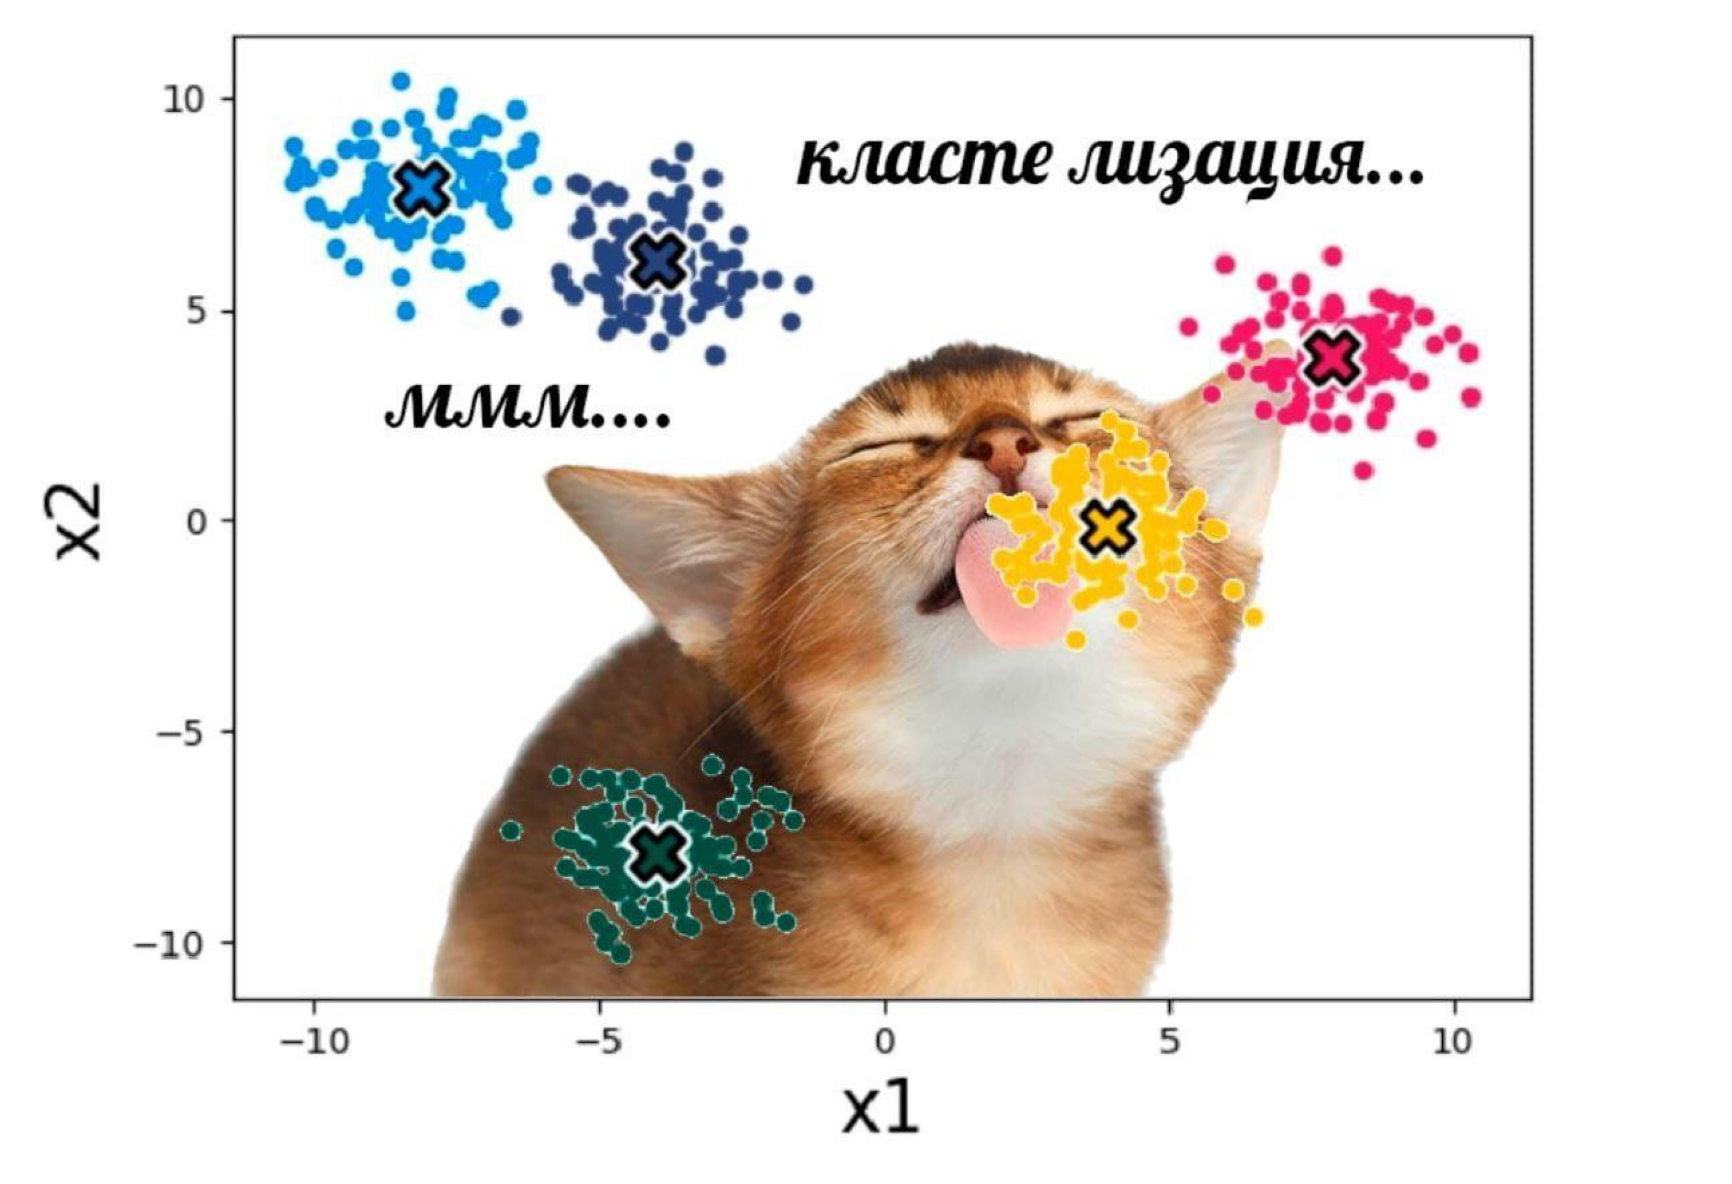

In [34]:
image = read_image("photo.jpg")
show_image(image)

Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [35]:
def clusterize_image(image: ndarray, n_clusters: int):
    flattened = image.reshape(-1, 3)
    model = KMeans(n_clusters=n_clusters, init="kmeans++")
    model.fit(flattened)
    cluster_colors = model._centroids
    clusters = model.predict(flattened)
    recolored = cluster_colors[clusters].reshape(image.shape)
    
    clusters_statistics(flattened, cluster_colors, clusters)
    return recolored

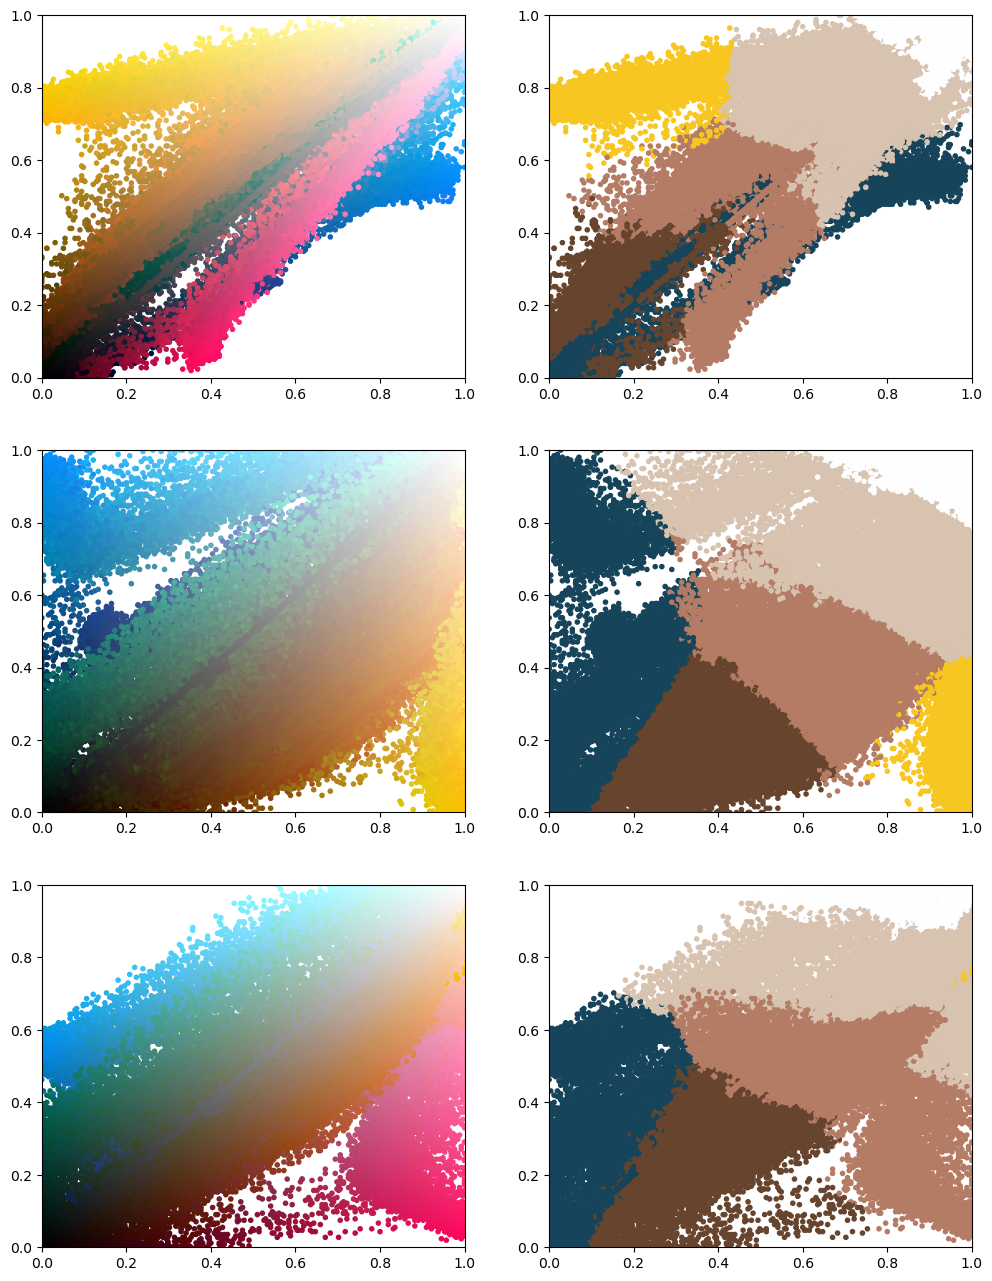

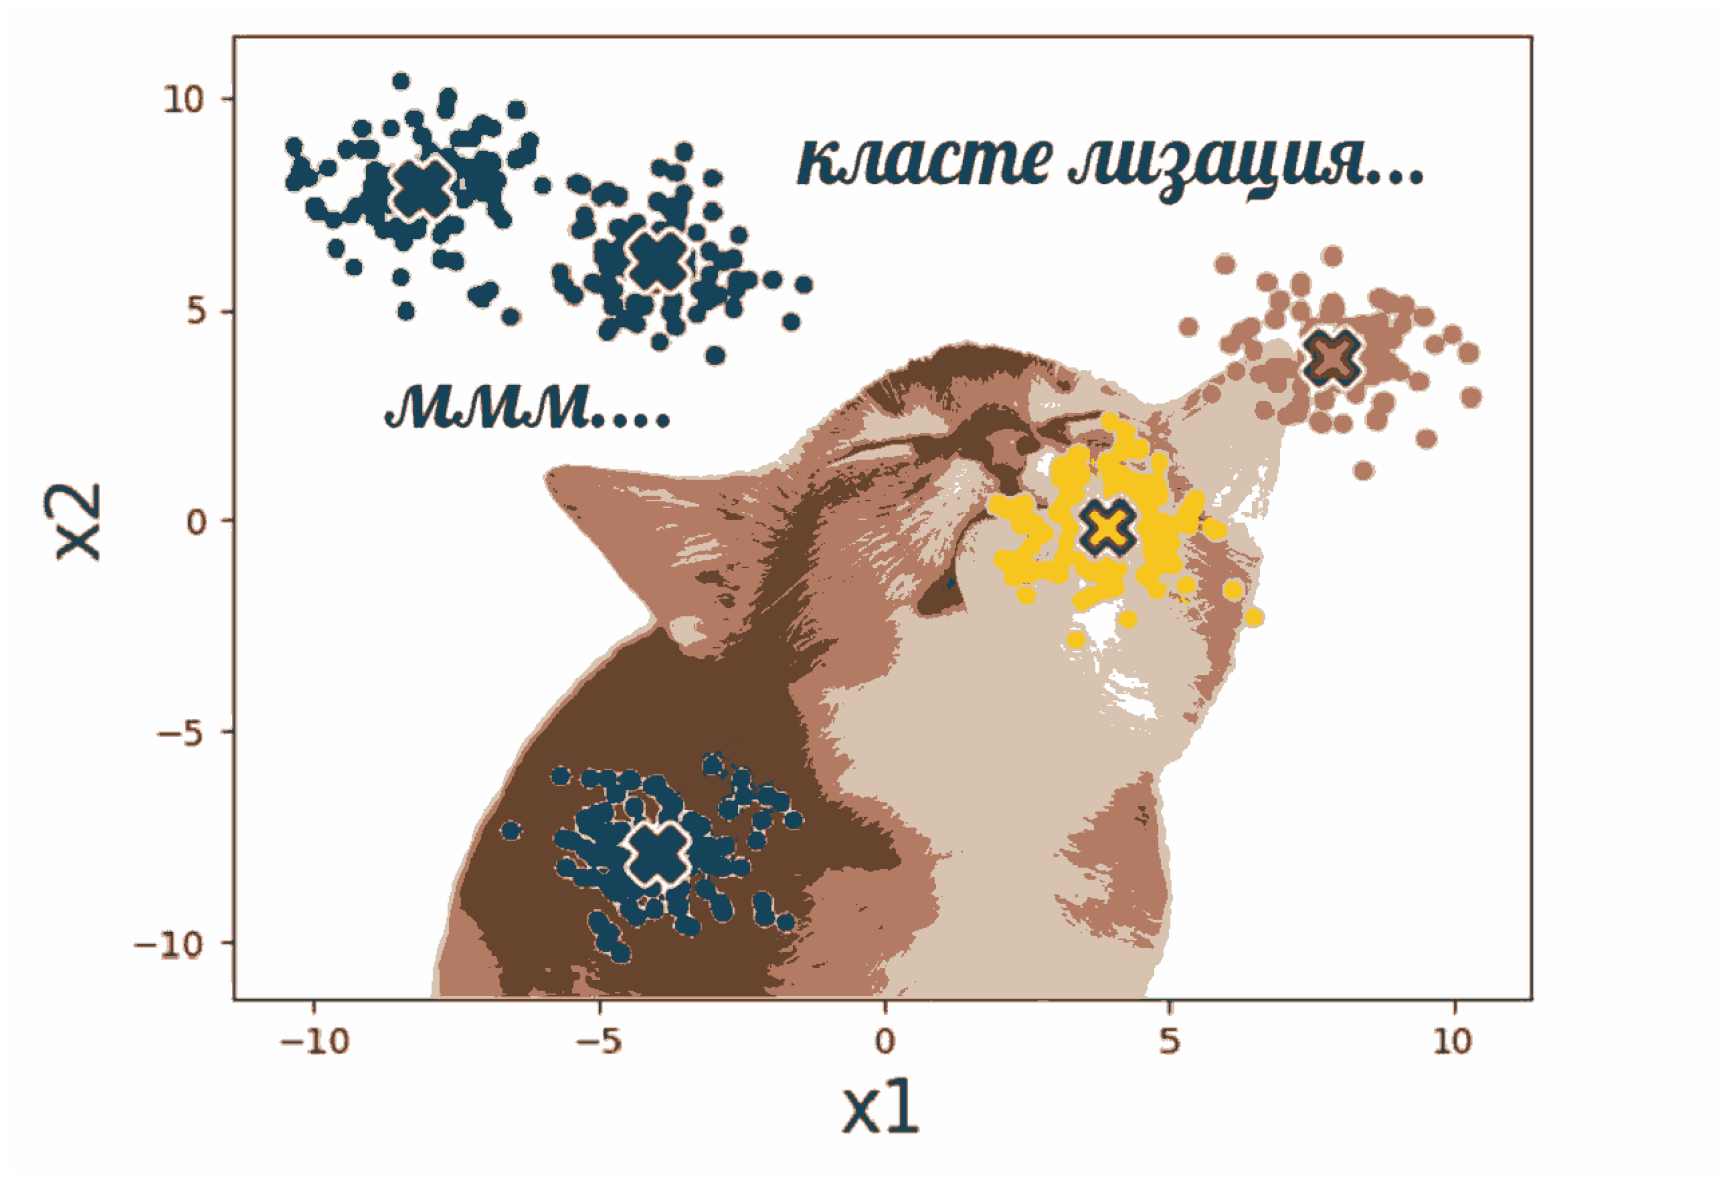

In [40]:
result = clusterize_image(image, n_clusters=6)
show_image(result)
save_image(result, "result.jpg")